In [1]:
# full import

# data loading
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# create model/algorithms
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# evaluate models
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# multiclass classifier
from sklearn.multiclass import OneVsOneClassifier

In [2]:
# in chapter 1 we mentioned that the most common supervised learning tasks are:
#   # regression (predicting values)
#   # classification (predicting classes)
# in chapter 2 we explored a regression task, using various algorithm such as:
#   # Linear Regression
#   # Decision Trees
#   # Random Forests
# now we will turn our attention to classification systems

# MNIST


In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST. Whenever someone learns Machine Learning, sooner or later they tackle MNIST.


**Warning**: since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. To avoid this and keep the same code as in the book, we use as_frame=False

In [3]:
# scikit-learn provides many helper functions to download popular datasets. MNIST is one of them
# the following code fetches the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

# datasets loaded by scikit-learn generally have a similar dictionary structure including:
#   # a 'DESCR' key describing the dataset
#   # a 'data' key containing an array with one row per instance and one column per feature
#   # a 'target' key containing an array with labels 

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
# let's look at these arrays
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

# there are 70000 images and each image has 784 features
# this is because each image is 28x28 pixels, and each feature represents one pixel's intensity (from 0 to 255)

(70000, 784)
(70000,)


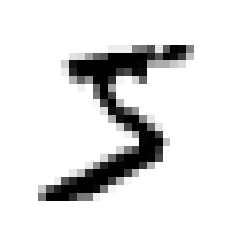

the label tells us that this number is: 5
labels type: <class 'str'>


In [5]:
# let's take a peek at one digit from the dataset
# all you need to do is:
#   # grab an instance's feature vector
#   # reshape it to a 28x28 array
#   # display it using Matplotlib's imshow() function
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis('off')
plt.show()
print('the label tells us that this number is:', y[0])
print('labels type:', type(y[0]))

In [6]:
# note that the label is a string
# we prefer numbers, so let's cast y to integers
y = y.astype(np.uint8)

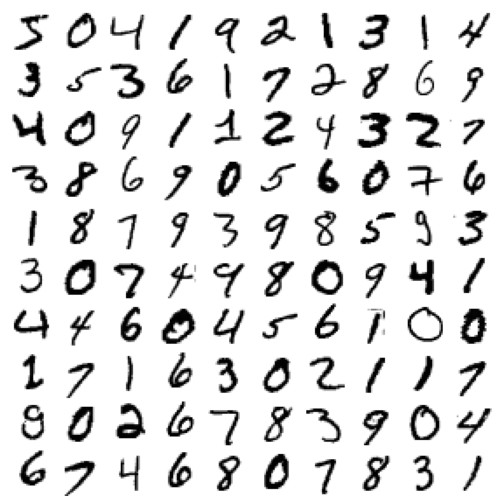

In [7]:
# Here we show more images of numbers in the MNIST dataset 
# (you don't need to know how to do this, it's just to help you visualize the data)

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9, 9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [8]:
# you should always create a test set and set it aside before inspecting the data closely
# the MNIST dataset is actually already split into 
# a training set (the first 60000 images)
# a test set (the last 10000 images)

X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# the training set is already shuffled for us
# which is good as this guarantees that all cross-validation folds will be similar
# moreover, some learning algorithms are sensitive to the order of the training instances
# and they perform poorly if they get many similar instances in a row
# shuffling the dataset ensures that this won't happen

# Training A Binary Classifier

In [9]:
# let's simplify the problem for now and only try to identify one digit - for example: 5
# this "5-detector" will be an example of a 'binary classifier'
# capable of distinguishing between just two classes, 5 and not 5
# let's create the target vectors for this classification task

y_train_5 = (y_train == 5) # True for all 5s, False for other digits
y_test_5 = (y_test == 5)

In [10]:
# now let's pick a classifier and train it
# a good place to starts is with a Stochastic Gradient Descent (SGD), using scikit-learn's SGDClassifier class
# this classifier has the advantage of being capable of handling every large dataset efficiently
# this is part because SGD deals with training instances independently, one at a time
# (which also makes SGD well suited for 'online learning'), as we will see later

# let's create an SGDClassifier and train it on the whole training set
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
# now you can use it to detect images of the number 5
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

In [12]:
# evaluating a classifier is often significantly trickier than evaluating a regressor
# so we will spend a large part of this chapter on this topic
# there are many performance measures
# so grab another coffee and get ready to learn many new concepts and acronyms!

## Measuring Accuracy Using Cross-Validation

In [13]:
# a good way to evaluate a model is to use cross-validation
# just as you did in chapter 2 

### Implementing Cross-Validation


Occasionally you will need more control over the cross-validation process than what scikit-learn provides off-the-shelf. In these case, you can implement cross-validation yourself; it is actually fairly straightforward.


The following code does roughly the same thing as scikit-learn's **cross_val_score()** function, and print the same result:

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred)) 

# the StratifiedKFold class performs stratified sampling
# to produce folds that contain a representative ratio of each class
# at each iteration the code creates a clone to the classifier, train the clone on the training folds, 
# and makes predictions on the test fold
# then it counts the number of correct predictions and outputs the ratio of correct predictions

0.9669
0.91625
0.96785


In [15]:
# let's use cross_val_score() function to evaluate your SGDClassifier model
# using K-fold cross-validation, with 3 folds

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# > 93% accuracy on all cross-validation folds?
# this looks amazing, doesn't it?
# but before you get too excited, let's do some more testing

array([0.95035, 0.96035, 0.9604 ])

In [16]:
# let's look at a very dumb classifier that just classifies every single image in the "not-5" class

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
# can you guess the model's accuracy? let's find out
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# it has over 90% accuracy 
# this is because only about 10% of the images are 5s
# so if you always guess that an image is not a 5, you will be right about 90% of the time
# this demonstrates why accuracy is generally not the perfect performance measure for classifiers
# especially when you are dealing with 'skewed datasets'

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [17]:
# a much better way to evaluate the performance of a classifier is to look at the 'confusion matrix'
# the general idea is to count the number of times instances of class A are classified as class B
# to compute the confusion matrix, you first need to have a set of predictions
# so they can be compared to actual targets
# you could make predictions on the test set, but let's keep it untouched for now
# (remember that you want to use the test set only at the very end of the project, 
# once you have a classifier that you are ready to launch)

# instead, you can use the cross_val_predict() function
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation
# but instead of returning the evaluation score, it returns the prediction made on each test fold
# this means that you get a clean prediction for each instance in the training set
# ("clean" meaning that the prediction is made by a model that never saw the data during training)

In [18]:
# now you are ready to get the confusion matrix using the confusion_matrix() function
# just pass it the target class (y_train_5) and the predicted classes (y_train_pred)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

# each row in a confusion matrix represents an 'actual class'
# each column represent a 'predicted class'

# the first row of this matrix considers non-5 images (negative class)
#   # the [0][0] index are predicted as non-5s (true negatives)
#   # the [0][1] index are predicted as 5s (false negatives)
# the second row of this matrix considers the images of 5s (positive class)
#   # the [1][0] index are predicted as non-5s (false positives)
#   # the [1][1] index are predicted as 5s (true positives)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [19]:
# a perfect classifier would have only true positives and true negatives
# so its confusion matrix would have non-zero values on its main diagonal

y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision and Recall


The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the **precision** of the classifier.

>$\text{precision} = \dfrac{TP}{TP + FP}$


**Notation**:
- $TP$: the number of true positives.
- $FP$: the number of false positives.

---

Precision is typically used along with another metric named **recall**, also called *sensitivity* or *true positive rate* (*TPR*): this is the ratio of positive instances that are correctly detected by the classifier.

>$\text{recall} = \dfrac{TP}{TP+FN}$


**Notation**:
- $TP$: the number of true positives.
- $FN$: the number of false negative.

In [20]:
# scikit-learn provides several functions to compute classifier metrics, using precision and recall

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))  # 0.8370879772350012
print(recall_score(y_train_5, y_train_pred))  # 0.6511713705958311

# now your 5-detector does not look as shiny as it did when you looked at its accuracy
# when it claims an image represents a 5, it is correct only 83.7% of the time
# moreover, it only detects 65.1% of the 5s

0.8370879772350012
0.6511713705958311


### F1 Score


it is often convenient to combine precision and recall into a single metric called the *F1 score*. in particular, if you need a simple way to compare two classifiers. the **F1 score** is the *harmonic mean** of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precion are high.


> $\text{F1} = \cfrac{2}{\dfrac{1}{\text{precision}} + \dfrac{1}{\text{recall}}} = 2 \times \dfrac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \cfrac{TP}{TP+\dfrac{FN+FP}{2}}$

In [21]:
# to compute the F1 score, simply call the f1_score() function

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

# the f1 score favors classifiers that have similar precision and recall
# this is not always what you want
# in some contexts you mostly care about precision, and in other contexts you really care about recall

# unfortunately, you can have it both ways
# increasing precision reduces recall, and vice versa
# this is called the 'precision/recall tradeoff'

0.7325171197343846

## Precision/Recall Tradeoff

In [22]:
# to understand this tradeoff, let's look at how the SGDClassifier makes its classification decisions
# for each instance, it computes a score based on a decision function
# and if that score is greater than a threshold, it assigns the instance to the positive class
# or else it assigns it to the negative class

# scikit-learn does not let you set the threshold directly 
# but it does give you access to the decision scores that it uses to make predictions
# instead of calling the classifier's predict() method, you can call its decision_function() method
# which returns a score for each instance
# and then make predictions based on those scores using any threshold you want

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0 # the SGDClassifier uses a threshold equal to 0
print(y_scores > threshold)

[2164.22030239]
[ True]


In [23]:
# let's raise the threshold

threshold = 8000
y_scores > threshold 

# this confirms that raising the threshold decreases recall
# the image actually represents a 5
# and the classifier detects it when threshold=0, but it misses it when threshold=8000

array([False])

In [24]:
# now how do you decide which threshold to use?
# for this, you first need to get the scores of all instances in the training set using the cross_val_predict() function
# this time specifying that you want it to return decision scores instead of predictions

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

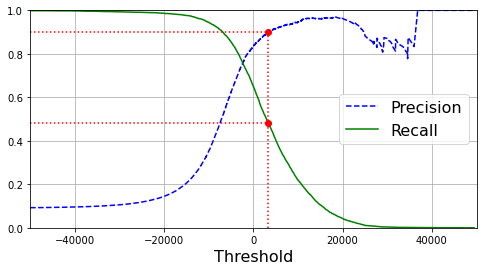

In [25]:
# now with these scores, you can compute precision and recall for all possible threshold 
# using the precision_recall_curve() function

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# finally, you can plot precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000,0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds) # plot the actual information
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

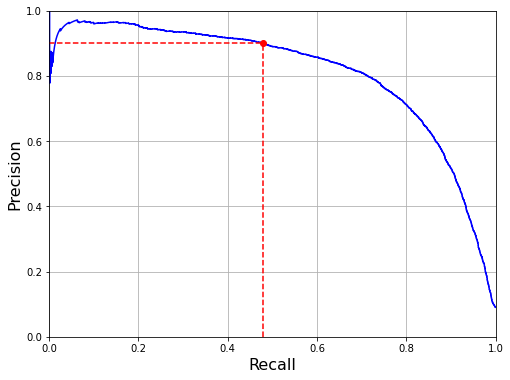

In [26]:
# another way to select a good precision/recall tradeoff 
# is to plot precision directly against recall

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, 'b-') # plot the actual information
plt.axis([0., 1., 0., 1.])
plt.grid(True)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.plot([0., recall_90_precision], [0.9, 0.9], 'r--')
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], 'r--')
plt.plot([recall_90_precision], [0.9], 'ro')

# you can see that precision really starts to fall sharply around 80% recall
# you will probably want to select a precision/recall tradeoff just before that drop

In [27]:
# so let's suppose you decide to aim for 90% precision

# first you need to calculate the threshold
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

# to make predictions (on the training set for now)
# instead of calling the classifier's predict() method, you can just run this code
y_train_pred_90 =  (y_scores >= threshold_90_precision)

# let's check these predictions' precision and recall
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

# great! now you have a 90% precision classifier
# but remember: a high-precision classifier is not very useful if its recall is too low

0.9000345901072293
0.4799852425751706


## The ROC Curve


The *receiver operating characteristic* (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision vs recall, the ROC curve plots the *true positive rate* (another name for recall) against the *false positive rate* (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive.


>$FPR = \dfrac{FP}{FP + TN} = 1 - TNR$


**Notation**:
- $FP$: the number of false positives.
- $TN$: the number of true negatives.
- $TNR$: the *True Negative Rate* (specificity).

In [28]:
# to plot the ROC curve, you first need to compute the TPR and FPR for various threshold values
# using the roc_curve() function

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

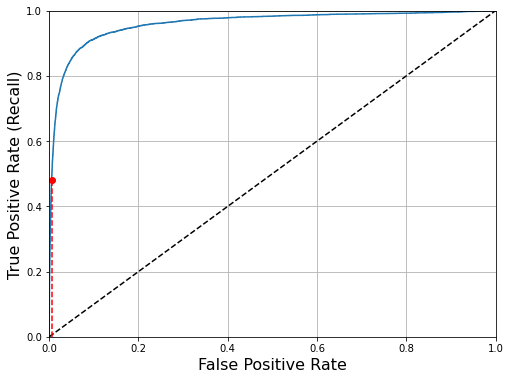

In [29]:
# then you can plot the FPR against the TPR using matplotlib

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr) # plot the actual information
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], 'r--')
plt.plot([0., fpr_90], [recall_90_precision, recall_90_precision], 'r--')
plt.plot([fpr_90], [recall_90_precision], 'ro')
plt.show()

# once again there is a tradeoff
# the higher the recall (TPR), the more false positive (FPR) the classifier produces
# the dotted line represents the ROC curve of a purely random classifier
# a good classifier stays as far away from that line as possible (toward the top-left corner)

## ROC AUC Score


one way to compare classifiers is to measure the *Area Under the Curve* (AUC). 


A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [30]:
# scikit-learn provides a function to compute the ROC AUC

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

# since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use
# as a rule of thumb, 
#   # you should prefer the PR curve whenever the positive class is rare 
#   # or when you care more about the false positives than the false negatives
#   # and the ROC curve otherwise

# For example
# looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good
# but this is mostly because there are few positives(5s) compared to the negatives (non-5s)
# in contrast, the PR curve makes it clear that the classifier has room for improvement
# (the curve could be closer to the topright corner)

0.9604938554008616

In [31]:
# let's train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier
# first you need to get scores for each instance in the training set
# but due to the way it works, the RandomForestClassifer class does not have a decision_function() method
# instead it has a predict_proba() method (sklearn generally have one or the other)
# the predict_proba() method returns an array containing a row per instance and a column per class
# each containing the probablility that the given instance belongs to the given class

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

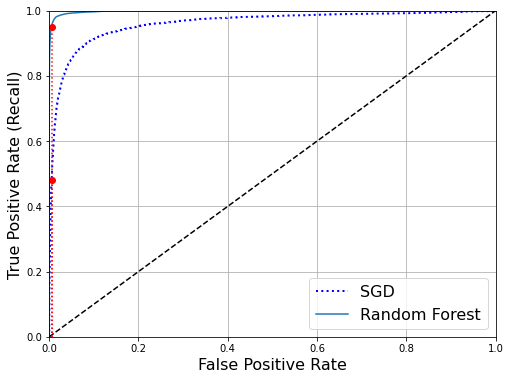

In [32]:
# but to plot a ROC curve, you need scores, not probabilities
# a simple solution is to use the positive class's probability as the score

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# now you are ready to plot the ROC curves

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [33]:
# as you can see, the RandomForestClassifier's ROC curve looks much better than the SGDClassifer's
# it comes much closer to the top-left corner 
# as a result, it ROC AUC score is also significantly better

print("ROC AUC:", roc_auc_score(y_train_5, y_scores_forest))

# we can also measure precision and recall
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print("Precision:", precision_score(y_train_5, y_train_pred_forest))
print("Recall:", recall_score(y_train_5, y_train_pred_forest))

# hopefully you now know how to train binary classifiers, choose the appropriate metric for your task
# evaluate your classifiers using cross-validation, select the precision/recall tradeoff that fits your needs
# and compare various models using ROC curves and ROC AUC scores
# now let’s try to detect more than just the 5s

ROC AUC: 0.9983436731328145
Precision: 0.9905083315756169
Recall: 0.8662608374838591


# Multiclass Classification


Whereas binary classifiers distinguish between two classes, **multiclass classifiers** (also called *multinominal classifiers*) can distinguish between more than two classes.


Some algorithms (such as *Random Forest* or *naive Bayes* classifiers) are capable of handling multiple classes directly. Others (such as *Support Vector Machine* classifiers or *Linear classifiers*) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers:
- One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector,...). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the **one-versus-all** (OvA) strategy 
- Another startegy is to train a binary classifier for every pair of digits (distinguish 0s and 1s, distinguish 0s and 2s, distinguish 1s and 2s,...). This is called the **one-versus-one** (OvO) strategy. If there are N classes, you need to train $\left[N \times \frac{(N-1)}{2}\right]$ classifiers. When you want to classify and image, you have to run the image through all 45 classifiers and see which class wins the most duels.
    - The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.


Some algorithms (such as *Support Vector Machine*) scale poorly with the size of the training set, so for these algorithms *OvO is preferred* since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, *OvA is preferred*.

In [40]:
# scikit-learn detects when you try to use a binary classification algorithm for a multiclass classification task
# and it automatically runs OvA (except for SVM classifiers for which it uses OvO)

# let's try this with the SGDClassifier
sgd_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
sgd_clf.predict([some_digit])

# this code trains the SGDClassifier on the training set using the original target classes from 0 to 9 (y_train)
# instead of the 5-versus-all target classes (y_train_5)
# then it makes a prediction, it could predict 5 or 3. Who knows :>>
# under the hood: 
#   # scikit-learn actually trained 10 binary classifiers, 
#   # got their decision scores for the image, 
#   # and selected the class with the highest score

array([5], dtype=uint8)

In [41]:
# to see that this is indeed the case, you can call the decision_function() method
# instead of returning just one score per instance, it now returns 10 scores, one per class

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-6049581.97985829, -6138036.45541781, -3886281.38604606,
         -604692.42366776, -6948311.32017536,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

In [46]:
# if you want to force scikit-learn to use one-versus-one or one-versus-all
# you can use the OneVsOneClassifier or OneVsAllClassifier classes
# simply create an instance and pass a binary classifier to its constructor 

# for example, this code creates a multiclass classifier using the OvO strategy, base on a SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=1000, tol=1e-3, random_state=42))
ovo_clf.fit(X_train[:1000], y_train[:1000])
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5]
45


In [47]:
# training a RandomForestClassifier is just as easy 
forest_clf.fit(X_train[:1000], y_train[:1000])
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
# this time scikit-learn did not have to run OvA or OvO 
# because Random Forest classifiers can directly classify instances into multiple classes
# you can call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class

forest_clf.predict_proba([some_digit])

array([[0.03, 0.01, 0.02, 0.07, 0.  , 0.75, 0.03, 0.02, 0.02, 0.05]])

In [49]:
# now of course you want to evaluate these classifiers
# as usual, you want to use cross-validation
# let's evaluate the SGDClassifier's accuracy using the cross_val_score() function

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [53]:
# the score is not bad, but you can do better
# for example, simply scaling the input (as discussed in Chapter 2) increases the accuracy

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

# Error Analysis


Of course, if this were a real project, you would follow the steps in your Machine Learning project checklist: exploring data preparation options, trying out multiple models, shortlisting the best ones and fine-tuning their hyperparameters using GridSearchCV, and automating as much as possible, as you did in previous chapter.


Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

In [54]:
# first, you can look at the confusion matrix
# you need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

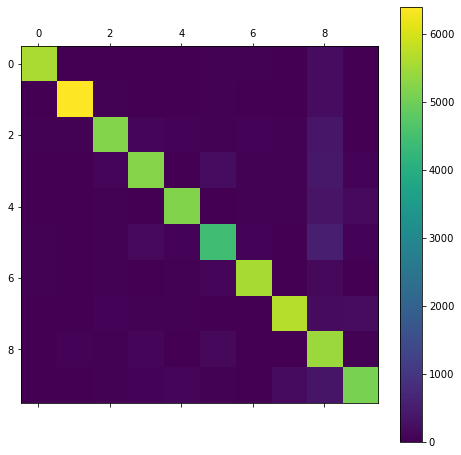

In [66]:
# that's a lot of numbers 
# it's often more convenient to look at an image represetation of the confusion_matrix
# using matplotlib's matshow() function

def my_plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

my_plot_confusion_matrix(conf_mx)

# this confusion matrix looks fairly good, since most images are on the main diagonal
# which means that they were classified correctly
# the 5s looks slightly darker than the other digits, 
# which could mean that there are fewer images of 5s in the dataset 
# or that the classifier does not perform well on 5s as on the other digits
# in fact, you can verify that both are the case

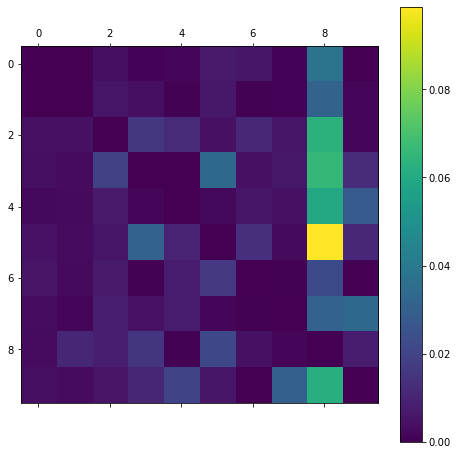

In [68]:
# let's focus the plot on the errors
# first, you need to divide each value in the confusion matrix by the number of images in the corresponding class
# so you can compare error rates instead of absolute number of errors
# (which would make abundant classes look unfairly bad)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# now let's fill the diagonal with zeros to keep only the errors, and let's plot the result

np.fill_diagonal(norm_conf_mx, 0)
my_plot_confusion_matrix(norm_conf_mx)

# now you can clearly see the kinds of errors the classifier makes
# remember that rows represent actual classes, while columns represent predicted classes
# the column for 8 is quite bright, which tells you that many images get misclassified as 8s
# however, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s
# as you can see, the confusion matrix is not necessarily symmetrical 
# you can also see that 3s and 5s often get confused (in both directions)

# Analyzing the confusion matrix can often give you insights on ways to improve your classifier
# looking at this plot, it seems that your efforts should be spent on reducing the false 8s
# for example, you could try to gather more training data for digits that look like 8s (but are not) 
# so the classifier can learn to distinguish them from real 8s 
# or you could engineer new features that would help the classifier
# for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none) 
# or you could preprocess the images(e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops


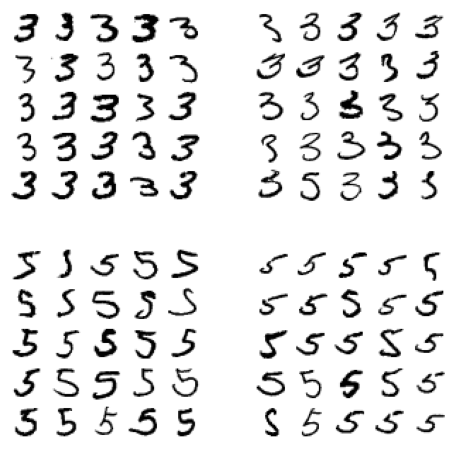

In [70]:
# analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing
# but it is more difficult and time-consuming
# for example, let's plot examples of 3s and 5s 
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)

In [71]:
# the two 5×5 blocks on the left show digits classified as 3s
# and the two 5×5 blocks on the right show images classified as 5s.
# Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks)
# are so badly written that even a human would have trouble classifying them
# however, most misclassified images seem like obvious errors to us,
# and it’s hard to understand why the classifier made the mistakes it did
# the reason is that we used a simple SGDClassifier, which is a linear model
# all it does is assign a weight per class to each pixel
# and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class
# so since 3s and 5s differ only by a few pixels, this model will easily confuse them

# the main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc
# if you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa
# in other words, this classifier is quite sensitive to image shifting and rotation
# so one way to reduce the 3/5 confusion would be to preprocess the images
# to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well

# Multilabel Classification


Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. For example, consider a face-recognition classifier: what should it do if it recognizes several people on the same picture? Of course it should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). 


Such a classification system that outputs multiple binary tags is called a **multilabel classification** system.

In [72]:
# let's look at a simple example, just for illustration purposes

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [73]:
# now you can make prediction, and notice that it outputs two labels
# and it gets it right! the digit 5 is indeed not large (False) and odd (True)

knn_clf.predict([some_digit])

array([[False,  True]])

In [74]:
# There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project
# for example, one approach is to measure the F1 score for each individual label 
# (or any other binary classifier metric discussed earlier), 
# then simply compute the average score

# this code computes the average F1 score across all labels
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# this assumes that all labels are equally important, which may not be the case 
# in particular, it you have many more pictures of Alice than Bob or Charlie
# you may want to give more weight to the classifier's score on pictures of Alice
# one simple solution is to give each label a weight equal to its 'support'
# (i.e. the number of instances with that target label)
# to do this, simply set average="weighted" in the preceding code

0.976410265560605

# Multioutput Classification


The last type of classification task we are going to discuss here is called **multioutput-multiclass classification** (or simply **multioutput classification**). It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

In [76]:
# to illustrate this, let’s build a system that removes noise from images
# it will take as input a noisy digit image, and it will(hopefully) output a clean digit image
# represented as an array of pixel intensities, just like the MNIST images. 
# notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple
# values (pixel intensity ranges from 0 to 255)
# it is thus an example of a multioutput classification system

# let's start by creating the training and test sets by taking the MNIST images 
# and adding noise to their pixel intensities using Numpy's randint() function
# the target images will be the original images

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

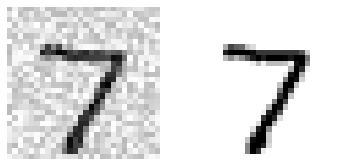

In [77]:
# let's take a peek at an image from the test set
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

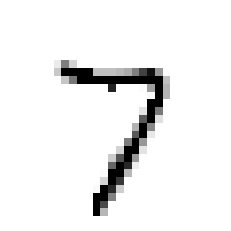

In [78]:
# now let's train the classifier and make it clean this image
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# looks close enough to the target! 


In [ ]:
# this concludes our tour of classification
# hopefully you should now know how to select good metrics for classification tasks, 
# pick the appropriate precision/recall tradeoff, compare classifiers, 
# and more generally build good classification systems for a variety of tasks